In [ ]:
!pip install pystan==2.19.1.1
!pip install prophet


In [ ]:
import pandas as pd
import numpy as np 
from prophet import Prophet

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/xxiang27/sikkaAIHackathon/main/data_file.csv')
df.head()

,id,month,year,visits,no_of_appts,production
0,34,3,2014,1,960,76.55
1,34,4,2014,488,1089,106333.80
2,34,5,2014,831,993,192230.40
3,34,6,2014,753,884,163515.12
4,34,7,2014,721,797,160185.90


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27170 entries, 0 to 27169
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           27170 non-null  int64  
 1   month        27170 non-null  int64  
 2   year         27170 non-null  int64  
 3   visits       27170 non-null  int64  
 4   no_of_appts  27170 non-null  int64  
 5   production   27170 non-null  float64
dtypes: float64(1), int64(5)
memory usage: 1.2 MB


In [ ]:
df.describe()

,id,month,year,visits,no_of_appts,production
count,27170.000000,27170.000000,27170.000000,27170.000000,27170.000000,2.717000e+04
mean,141.936069,6.582149,2015.817372,567.629923,272.300184,1.810539e+05
std,81.682146,3.457194,3.018620,380.785944,380.348904,1.340010e+05
min,1.000000,1.000000,2010.000000,1.000000,1.000000,-1.592922e+05
25%,73.000000,4.000000,2013.000000,321.000000,18.000000,9.867377e+04
50%,143.000000,7.000000,2016.000000,479.000000,144.000000,1.498361e+05
75%,210.000000,10.000000,2018.000000,724.000000,403.000000,2.239591e+05
max,284.000000,12.000000,2020.000000,3229.000000,4147.000000,1.230910e+06


In [ ]:
def turntoDate(df):
  lst = []
  for i in range(len(df)):
    lst.append(pd.Timestamp(year = df.loc[i, 'year'], month = df.loc[i, 'month'], day=None))
  df['date'] = lst
  return df

In [ ]:
df['day'] = 1
dates = pd.to_datetime(df[['month', 'year','day']].copy())
dates.head()

0   2014-03-01
1   2014-04-01
2   2014-05-01
3   2014-06-01
4   2014-07-01
dtype: datetime64[ns]

In [ ]:
df_final = pd.concat([dates, df],axis=1)
#df_final = df_final.drop(columns = ['month', 'year', 'day'])
df_final.columns.values[0] = 'date'
df_final.head()

,date,id,month,year,visits,no_of_appts,production,day
0,2014-03-01,34,3,2014,1,960,76.55,1
1,2014-04-01,34,4,2014,488,1089,106333.80,1
2,2014-05-01,34,5,2014,831,993,192230.40,1
3,2014-06-01,34,6,2014,753,884,163515.12,1
4,2014-07-01,34,7,2014,721,797,160185.90,1


In [ ]:
# separate dataframe into separate dataframes for each practice 

import math 

def separate(df):
  '''takes a dataframe returns a list of dataframes, 
  one for each unique value under the id column'''
  lst = []
  grouped = df.groupby(df.id)
  for i in range(1, 285):
    lst.append(grouped.get_group(i))
  return lst 

def train_test_split(lst, add_test):
  '''takes a list of dataframes and returns the time series train and test split based on the percent'''
  test_set = []
  for df in lst:
    #df_add = df.tail(add_test)
    df_add = df.tail(add_test).copy()
    test_set.append(df_add)
    df.drop(df.tail(add_test).index, inplace = True)
  #df_train = pd.concat(lst, ignore_index=True)
  #df_test = pd.concat(test_set, ignore_index = True)
  return lst, test_set

def find_final(lst):
  months_lst = []
  years_lst = []
  weird_ids = []
  for df in lst: 
    month = df.tail(1).iloc[0,2]
    months_lst.append(month)
    year = df.tail(1).iloc[0,3]
    years_lst.append(year)
    if month != 12 or year != 2020:
      weird_ids.append(df.tail(1).iloc[0,1])
  return months_lst, years_lst, weird_ids




In [ ]:
df_final.tail(1).iloc[0,0]

Timestamp('2020-12-01 00:00:00')

In [ ]:
train_lst = separate(df_final)
months, years, weird = find_final(train_lst)

In [ ]:
df_final.head()

,date,id,month,year,visits,no_of_appts,production,day
0,2014-03-01,34,3,2014,1,960,76.55,1
1,2014-04-01,34,4,2014,488,1089,106333.80,1
2,2014-05-01,34,5,2014,831,993,192230.40,1
3,2014-06-01,34,6,2014,753,884,163515.12,1
4,2014-07-01,34,7,2014,721,797,160185.90,1


(array([  3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 281.]),
 array([11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ]),
 <a list of 10 Patch objects>)

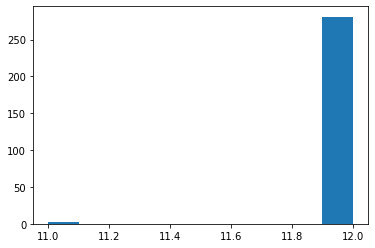

In [ ]:
import matplotlib.pyplot as plt
plt.hist(months)

(array([  0.,   0.,   0.,   0., 284.]),
 array([2015., 2016., 2017., 2018., 2019., 2020.]),
 <a list of 5 Patch objects>)

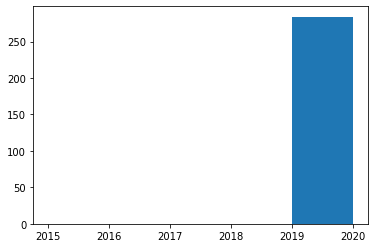

In [ ]:
plt.hist(years, bins = 5, range = [2015, 2020])

We see that three clinics (with ids show below) have date until 11/2020 instead of 12/2020. 

In [ ]:
weird

[66, 252, 262]

In [ ]:
2019 in years

False

We predict for the last 4 dates, since in the assignment they ask to predict the last 4 dates. We trust that Prophet will find and understand seasonality traits

In [ ]:
df_train, df_test = train_test_split(train_lst, 4)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We first fit a general prophet model, without any special seasonalities or regressors 

In [ ]:
def make_predictions(df_train):
  make_predictions = {}
  for df in df_train:
    X = df[['date', 'production']]
    id = df.iloc[0, 1]
    X.rename(columns={"date": "ds", "production": "y"}, inplace = True)
    m = Prophet()
    m.fit(X)
    future = m.make_future_dataframe(periods = 4, freq = 'MS')
    forecast = m.predict(future)
    pred = forecast.tail(4)['yhat'].to_numpy()
    make_predictions[id] = pred
  return make_predictions 
    


In [ ]:
predictions = make_predictions(df_train)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this

In [ ]:
def MAPE(y_true, y_pred):
	return np.mean(np.abs((y_true - y_pred)/y_true))*100

# need to make both of them dictionaries 
def score(predictions, actual):
  scores = []
  cate = [0,0,0,0]
  for i in range(1, 285):
    score = MAPE(actual[i], predictions[i])
    scores.append(score)
    if score <= 5:
      cate[0] += 1
    elif score > 5 and score <=10:
      cate[1] += 1
    elif score >10 and score <= 15:
      cate[2] += 1
    else:
      cate[3] += 1
  total_score = (cate[0]/284 * 2) + (cate[1]/284 * 1) + (cate[2]/284 * -1) + (cate[3]/284 * -2)
  return scores, total_score 

def prepare_test(df_test, name):
  actual = {}
  for df in df_test:
    id = df.iloc[0,1]
    actual[id] = df[name].to_numpy()
  return actual 

In [ ]:
actual = prepare_test(df_test)

In [ ]:
scores, total = score(predictions, actual)

In [ ]:
total

-1.2816901408450705

(array([189.,  66.,  14.,   6.,   4.,   3.,   0.,   1.,   0.,   1.]),
 array([  2.47702201,  24.73475125,  46.99248048,  69.25020972,
         91.50793895, 113.76566819, 136.02339743, 158.28112666,
        180.5388559 , 202.79658513, 225.05431437]),
 <a list of 10 Patch objects>)

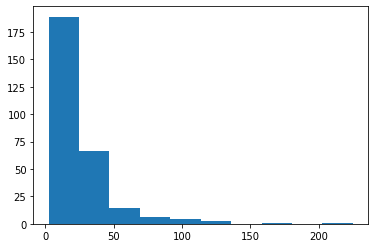

In [ ]:
plt.hist(scores)

In [ ]:
def prepare_train(df_train):
  train = {}
  for df in df_train:
    id = df.iloc[0,1]
    train[id] = df
  return train

def get_data_counts(train):
  counts = []
  for i in range(1, 285):
    df = train[i]
    counts.append(len(df))
  return counts


In [ ]:
counts = get_data_counts(prepare_train(df_train))


In [ ]:
# train_dict = prepare_train(df_train)
# train_dict

{1:             date  id  month  year  visits  no_of_appts  production  day
 10524 2016-10-01   1     10  2016       4            4     1854.70    1
 10525 2016-11-01   1     11  2016      31           32    11352.45    1
 10526 2016-12-01   1     12  2016      40           54    17854.65    1
 10527 2017-01-01   1      1  2017      27           39    11869.50    1
 10528 2017-02-01   1      2  2017      41           57    15596.90    1
 10529 2017-03-01   1      3  2017      57           74    18829.79    1
 10530 2017-04-01   1      4  2017      39           47    13316.97    1
 10531 2017-05-01   1      5  2017      49           55    18030.39    1
 10532 2017-06-01   1      6  2017      39           43    13284.82    1
 10533 2017-07-01   1      7  2017      39           68     8320.34    1
 10534 2017-08-01   1      8  2017      62           93    18239.45    1
 10535 2017-09-01   1      9  2017      64          101    21910.92    1
 10536 2017-10-01   1     10  2017      64      

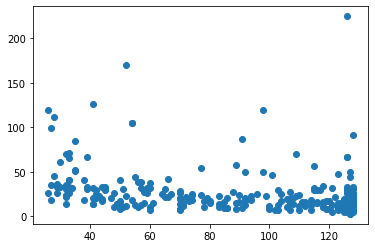

In [ ]:
plt.scatter(counts, scores)

(array([ 28.,  20.,  21.,  17.,  15.,  15.,  15.,  18.,  21., 114.]),
 array([ 26. ,  36.2,  46.4,  56.6,  66.8,  77. ,  87.2,  97.4, 107.6,
        117.8, 128. ]),
 <a list of 10 Patch objects>)

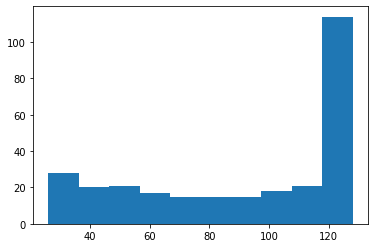

In [ ]:
plt.hist(counts)

In [ ]:
np.mean(scores)

25.519307501207063

In [ ]:
import copy
def make_predictions_monthly_seasonality(df_train, name):
  make_predictions = {}
  for df in df_train:
    X = df[['date', name]]
    id = df.iloc[0, 1]
    X.rename(columns={"date": "ds", name: "y"}, inplace = True)
    m = Prophet(seasonality_mode='multiplicative')
 #   m.add_seasonality(name = 'monthly', fourier_order = 5)
    m.fit(X)
    future = m.make_future_dataframe(periods = 4, freq = 'MS')
    forecast = m.predict(future)
    pred = forecast.tail(4)['yhat'].to_numpy()
    pred1 = forecast.tail(4)['yhat_upper'].to_numpy()
    pred2 = forecast.tail(4)['yhat_lower'].to_numpy()
    pred3 = forecast.tail(4)['trend'].to_numpy()
    pred4 = forecast.tail(4)['trend_lower'].to_numpy()
    pred5 = forecast.tail(4)['trend_upper'].to_numpy()
    make_predictions[id] = [pred,pred1,pred2,pred3,pred4,pred5]
  return make_predictions 

def make_predictions_base(df_train, name):
  make_predictions = {}
  for df in df_train:
    X = df[['date', name]]
    id = df.iloc[0, 1]
    X.rename(columns={"date": "ds", name: "y"}, inplace = True)
    m = Prophet(weekly_seasonality=False)
 #   m.add_seasonality(name = 'monthly', fourier_order = 5)
    m.fit(X)
    future = m.make_future_dataframe(periods = 4, freq = 'MS')
    forecast = m.predict(future)
    pred = forecast.tail(4)['yhat'].to_numpy()
    pred1 = forecast.tail(4)['yhat_upper'].to_numpy()
    pred2 = forecast.tail(4)['yhat_lower'].to_numpy()
    pred3 = forecast.tail(4)['trend'].to_numpy()
    pred4 = forecast.tail(4)['trend_lower'].to_numpy()
    pred5 = forecast.tail(4)['trend_upper'].to_numpy()
    make_predictions[id] = [pred,pred1,pred2,pred3,pred4,pred5]
  return make_predictions

def dentistry_season(ds):
  date = pd.to_datetime(ds)
  # high traffic
  if date.month in [11,12,1,2]:
    return 3 
  # med traffic
  if date.month in [8, 10,7, 4]:
    return 2
  # low traffic
  if date.month in [3,5,6,9]:
    return 1
  

def make_predictions_regressors(df_train, name):
  make_predictions = {}
  for df in df_train:
    X = df[['date', name]]
    id = df.iloc[0, 1]
    X.rename(columns={"date": "ds", name: "y"}, inplace = True)
    X['season'] = X['ds'].apply(dentistry_season)
    m = Prophet(weekly_seasonality=False, daily_seasonality=False, seasonality_mode='multiplicative')
   # m.add_regressor('no_of_appts')
    #m.add_regressor('visits')
 #   m.add_seasonality(name = 'monthly', fourier_order = 5)
    m.fit(X)
    future = m.make_future_dataframe(periods = 4, freq = 'MS')
    future['season'] = future['ds'].apply(dentistry_season)
    forecast = m.predict(future)
    pred = forecast.tail(4)['yhat'].to_numpy()
    pred1 = forecast.tail(4)['yhat_upper'].to_numpy()
    pred2 = forecast.tail(4)['yhat_lower'].to_numpy()
    pred3 = forecast.tail(4)['trend'].to_numpy()
    pred4 = forecast.tail(4)['trend_lower'].to_numpy()
    pred5 = forecast.tail(4)['trend_upper'].to_numpy()
    make_predictions[id] = [pred,pred1,pred2,pred3,pred4,pred5]
  return make_predictions

def score_more(predictions, actual):
  score_tot = []
  finals = []
  for j in range(6):
    scores = []
    cate = [0,0,0,0]
    for i in range(1, 285):
      score = MAPE(actual[i], predictions[i][j])
      scores.append(score)
      if score <= 5:
        cate[0] += 1
      elif score > 5 and score <=10:
        cate[1] += 1
      elif score >10 and score <= 15:
        cate[2] += 1
      else:
        cate[3] += 1
    total_score = (cate[0]/284 * 2) + (cate[1]/284 * 1) + (cate[2]/284 * -1) + (cate[3]/284 * -2)
    score_tot.append(copy.deepcopy(scores))
    finals.append(total_score)
  return score_tot, finals

In [ ]:
%%capture
pred_ms = make_predictions_monthly_seasonality(df_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Di

In [ ]:
scores, total = score_more(pred_ms, actual)

In [ ]:
total


[-1.2711267605633805,
 -1.176056338028169,
 -1.841549295774648,
 -1.221830985915493,
 -1.221830985915493,
 -1.2147887323943662]

(array([190.,  47.,  25.,  10.,   5.,   4.,   1.,   1.,   0.,   1.]),
 array([  2.76810089,  28.80397293,  54.83984496,  80.87571699,
        106.91158902, 132.94746106, 158.98333309, 185.01920512,
        211.05507715, 237.09094919, 263.12682122]),
 <a list of 10 Patch objects>)

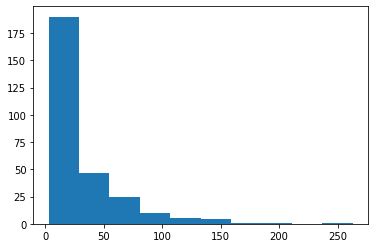

In [ ]:
plt.hist(scores[1])

In [ ]:
%%capture 
pred_base = make_predictions_base(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prop

In [ ]:
scores, total = score_more(pred_base, actual)

In [ ]:
total

[-1.2816901408450705,
 -1.1901408450704227,
 -1.8309859154929577,
 -1.232394366197183,
 -1.232394366197183,
 -1.232394366197183]

In [ ]:
%%capture 
pred_2reg = make_predictions_regressors(df_train)

INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoin

In [ ]:
scores, total = score_more(pred_2reg, actual)

In [ ]:
total

[-1.2711267605633805,
 -1.193661971830986,
 -1.8556338028169015,
 -1.221830985915493,
 -1.221830985915493,
 -1.2147887323943662]

In [ ]:
# with additive 
%%capture 
pred_2reg = make_predictions_regressors(df_train)

INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoin

In [ ]:
scores, total = score_more(pred_2reg, actual)

In [ ]:
total

[-1.2816901408450705,
 -1.1795774647887325,
 -1.8345070422535212,
 -1.232394366197183,
 -1.232394366197183,
 -1.232394366197183]

(array([185.,  52.,  30.,   6.,   4.,   3.,   1.,   0.,   2.,   1.]),
 array([  2.16924625,  27.83704032,  53.50483438,  79.17262844,
        104.8404225 , 130.50821656, 156.17601063, 181.84380469,
        207.51159875, 233.17939281, 258.84718687]),
 <a list of 10 Patch objects>)

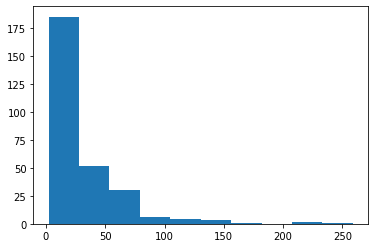

In [ ]:
plt.hist(scores[1])

In [ ]:
%%capture
score_v, total_v = score_more(make_predictions_regressors(df_train, 'visits'), prepare_test(df_test, 'visits'))


INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoin

In [ ]:
total_v

[-0.9014084507042254,
 -1.4471830985915493,
 -1.6514084507042253,
 -0.806338028169014,
 -0.8028169014084507,
 -0.806338028169014]

In [ ]:
%%capture
pred_visits1 = make_predictions_regressors(df_train, 'visits')
pred_visits2 = make_predictions_monthly_seasonality(df_train, 'visits')
pred_visits2 = make_predictions_base(df_train, 'visits')

INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoin

In [ ]:
score1, total1 = score_more(pred_visits1, actual)
score2, total2 = score_more(pred_visits2, actual)
#score3, total3 = score_more(pred_visits3, actual)

In [ ]:
total1

[-2.0, -2.0, -2.0, -2.0, -2.0, -2.0]

In [ ]:
total2

[-2.0, -2.0, -2.0, -2.0, -2.0, -2.0]